Total Fission Rate: 9.1194e+19 fissions/s
Flux at 1.0 MeV: 8.23e+12 nu/s/cm2/MeV
Flux at 3.0 MeV: 3.06e+11 nu/s/cm2/MeV


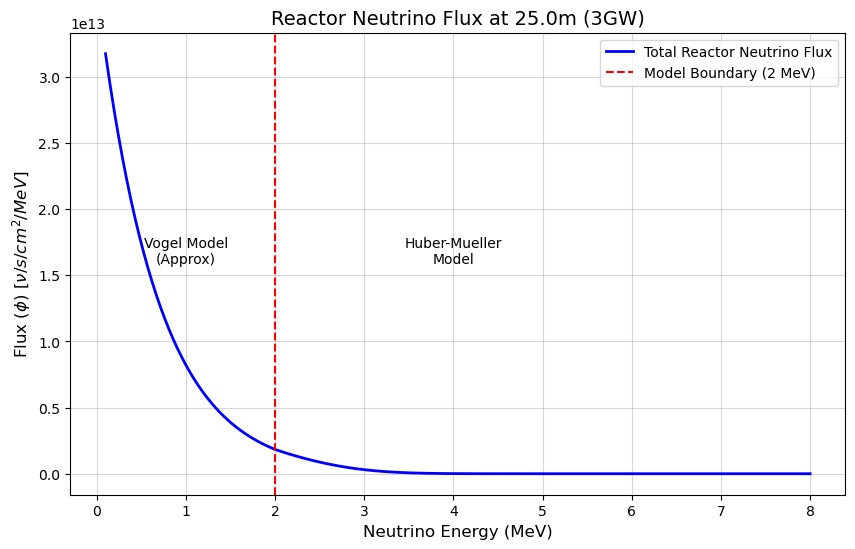

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 物理常数与输入参数
# ==========================================

# 反应堆参数
P_th_GW = 3.0           # 热功率 (GW)
P_th_Watts = P_th_GW * 1e9
Distance_m = 25.0       # 距离 (m)
Distance_cm = Distance_m * 100

# 燃料组分 (Fission Fractions)
frac = {
    'U235': 0.561,
    'U238': 0.076,
    'Pu239': 0.307,
    'Pu241': 0.056
}

# 每次裂变释放的平均能量 (MeV/fission)
# 参考: Ma et al., PRC 88 (2013)
Q_energy = {
    'U235': 201.92,
    'U238': 205.52,
    'Pu239': 209.99,
    'Pu241': 213.60
}

# 单位转换常数
MeV_to_Joules = 1.60218e-13

# ==========================================
# 2. Huber-Mueller 模型参数 (E > 2 MeV)
# ==========================================
# S(E) = exp(sum(a_k * E^k)) from k=1 to 6
# U235, Pu239, Pu241 来自 Huber (2011)
# U238 来自 Mueller (2011)

coeffs_HM = {
    'U235':  [4.367, -4.577, 2.100, -5.294e-1, 6.186e-2, -2.777e-3],
    'Pu239': [4.757, -5.392, 2.563, -6.596e-1, 7.820e-2, -3.536e-3],
    'Pu241': [2.990, -2.882, 1.278, -3.343e-1, 3.905e-2, -1.754e-3],
    'U238':  [4.833e-1, 1.927e-1, -1.283e-1, -6.762e-3, 2.233e-3, -1.536e-4]
}

def spectrum_huber_mueller(E, isotope):
    """
    计算 > 2 MeV 的中微子能谱 (Huber-Mueller)
    返回: neutrinos / MeV / fission
    """
    if isotope not in coeffs_HM:
        return 0

    # 简单的指数多项式计算
    # fit = exp(a1*E + a2*E^2 + ...)
    # 注意：论文中的系数定义通常对应 E^1 到 E^6
    c = coeffs_HM[isotope]
    exponent = 0
    for i, a in enumerate(c):
        exponent += a * (E**(i+1))

    return np.exp(exponent)

# ==========================================
# 3. Vogel 模型参数 (E < 2 MeV)
# ==========================================
def spectrum_vogel_approx(E, isotope):
    """
    计算 < 2 MeV 的中微子能谱 (Vogel Approximation)
    注意：真实的 Ref [54] (Vogel 1989) 数据通常是理论表格。
    这里使用理论低能区的通用近似公式： S(E) = exp(A + B*E)
    为了代码的连续性，这里使用一个能够平滑连接到 HM 模型的近似函数。

    实际科研中，应该将 Ref [54] 的数字化数据插值到这里。
    """
    # 这里我们使用一个简化的物理近似：
    # 低能区中微子主要来自长寿命核素，通量上升很快。
    # 为了演示，我们使用 Huber-Mueller 在 2MeV 处的切线向低能外推，
    # 或者使用一个典型的低能指数斜率。

    # 获取该同位素在 2 MeV 的值作为锚点
    val_at_2MeV = spectrum_huber_mueller(2.0, isotope)

    # 假设一个典型的低能斜率 (这只是一个近似，用于演示代码逻辑)
    # Vogel 模型的低能区通常比 HM 模型的直接外推要低或平缓一些
    slope = -1.5 # 经验值

    # S(E) = S(2MeV) * exp(slope * (E - 2))
    # E 越小，(E-2) 越负，exp 为正大数，通量上升
    return val_at_2MeV * np.exp(slope * (E - 2.0))

# ==========================================
# 4. 综合流强计算
# ==========================================

def total_flux_at_source(E):
    """
    计算每次平均裂变产生的中微子谱 (weighted sum)
    S_total(E) = sum( f_i * S_i(E) )
    """
    s_total = 0
    for iso, f in frac.items():
        if E >= 2.0:
            s_i = spectrum_huber_mueller(E, iso)
        else:
            s_i = spectrum_vogel_approx(E, iso)
        s_total += f * s_i
    return s_total

def calculate_flux():
    # 1. 计算平均每次裂变的能量 (Weighted Average Energy per Fission)
    avg_energy_per_fission_MeV = sum(frac[iso] * Q_energy[iso] for iso in frac)
    avg_energy_per_fission_J = avg_energy_per_fission_MeV * MeV_to_Joules

    # 2. 计算每秒总裂变数 (Fission Rate)
    # P = N_f * E_per_fission  =>  N_f = P / E_per_fission
    fission_rate = P_th_Watts / avg_energy_per_fission_J

    print(f"Total Fission Rate: {fission_rate:.4e} fissions/s")

    # 3. 几何因子 1 / (4 * pi * L^2)
    # L 必须用 cm，因为最后通量通常是 /cm^2
    geo_factor = 1.0 / (4 * np.pi * Distance_cm**2)

    # 4. 生成能谱数据
    # 能量范围：从 0.1 MeV 到 8 MeV (Huber-Mueller 高能端通常到8-10MeV)
    energies = np.linspace(0.1, 8.0, 500)
    fluxes = []

    for E in energies:
        # S_weighted 是每次裂变产生的中微子数
        S_weighted = total_flux_at_source(E)

        # Phi = N_f * S_weighted / (4*pi*L^2)
        phi = fission_rate * S_weighted * geo_factor
        fluxes.append(phi)

    return energies, np.array(fluxes)

# ==========================================
# 5. 执行与绘图
# ==========================================
E_vals, Flux_vals = calculate_flux()

# 输出几个关键点的数值供检查
print(f"Flux at 1.0 MeV: {np.interp(1.0, E_vals, Flux_vals):.2e} nu/s/cm2/MeV")
print(f"Flux at 3.0 MeV: {np.interp(3.0, E_vals, Flux_vals):.2e} nu/s/cm2/MeV")

plt.figure(figsize=(10, 6))
plt.plot(E_vals, Flux_vals, linewidth=2, color='blue', label='Total Reactor Neutrino Flux')

# 标记 2 MeV 分界线
plt.axvline(x=2.0, color='red', linestyle='--', label='Model Boundary (2 MeV)')
plt.text(1.0, max(Flux_vals)/2, 'Vogel Model\n(Approx)', horizontalalignment='center')
plt.text(4.0, max(Flux_vals)/2, 'Huber-Mueller\nModel', horizontalalignment='center')

# plt.yscale('log')
plt.xlabel('Neutrino Energy (MeV)', fontsize=12)
plt.ylabel('Flux ($\phi$) [$\\nu / s / cm^2 / MeV$]', fontsize=12)
plt.title(f'Reactor Neutrino Flux at {Distance_m}m (3GW)', fontsize=14)
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.show()

In [5]:
import numpy as np
from scipy.integrate import quad

def spectrum(E):
    # 根据图像拟合的公式: R(E) = 10^(5.6 - 4E)
    return 10**(5.6 - 4 * E)

# 积分范围
E_min = 0.3
E_max = 1.0

# 计算积分
integral, error = quad(spectrum, E_min, E_max)

print(f"积分结果 (0.3 - 1.0 keV): {integral:.2f}")
print(f"E=0.3 处的数值: {spectrum(0.3):.2f}")
print(f"E=1.0 处的数值: {spectrum(1.0):.2f}")

积分结果 (0.3 - 1.0 keV): 2722.92
E=0.3 处的数值: 25118.86
E=1.0 处的数值: 39.81
